# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
# TODO Implement cross-entropy loss
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

AttributeError: 'int' object has no attribute 'ndim'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [ ]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [8]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)
target_index = target_index[:,None]

_____

In [9]:
from linear_classifer import softmax_with_cross_entropy

In [10]:
predictions = np.dot(X, W)

In [11]:
loss, dprediction = softmax_with_cross_entropy(predictions, target_index)

In [12]:
dprediction

array([[ 0.88079708, -0.88079708],
       [ 0.04742587, -0.04742587]])

In [13]:
W

array([[ 1.,  2.],
       [-1.,  1.],
       [ 1.,  2.]])

In [14]:
X

array([[-1., -1.,  1.],
       [ 0.,  1.,  1.]])

In [15]:
#dW Для 1 примера
(X[:,None][0]*dprediction[0][:,None]).T

array([[-0.88079708,  0.88079708],
       [-0.88079708,  0.88079708],
       [ 0.88079708, -0.88079708]])

In [16]:
#dW Для 2 примера
(X[:,None][1]*dprediction[1][:,None]).T

array([[ 0.        , -0.        ],
       [ 0.04742587, -0.04742587],
       [ 0.04742587, -0.04742587]])

In [17]:
# dW Для всех примеров
(X[:,None]*dprediction[:,:,None]).sum(axis=0).T

array([[-0.88079708,  0.88079708],
       [-0.8333712 ,  0.8333712 ],
       [ 0.92822295, -0.92822295]])

______

In [18]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как



$$l2\space reg\space loss = regularization\space strength* \sum _{i=1}^{n}\sum _{j=1}^{k}w_{ij}^{2}$$

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [19]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [28]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 691.124925
Epoch 1, loss: 688.468902
Epoch 2, loss: 686.152711
Epoch 3, loss: 684.123331
Epoch 4, loss: 682.332852
Epoch 5, loss: 680.756151
Epoch 6, loss: 679.377668
Epoch 7, loss: 678.185364
Epoch 8, loss: 677.233609
Epoch 9, loss: 676.558508


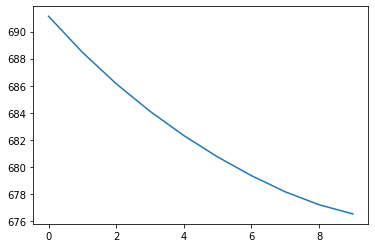

In [25]:
# let's look at the loss history!
plt.plot(loss_history)

In [29]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

Accuracy:  0.193


In [26]:
# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.193
Epoch 0, loss: 676.561813
Epoch 1, loss: 677.787533
Epoch 2, loss: 684.230758
Epoch 3, loss: 702.455770
Epoch 4, loss: 789.111637
Epoch 5, loss: 898.474649
Epoch 6, loss: 933.478716
Epoch 7, loss: 900.387284
Epoch 8, loss: 920.180257
Epoch 9, loss: 892.506119
Epoch 10, loss: 912.765760
Epoch 11, loss: 888.516304
Epoch 12, loss: 912.440129
Epoch 13, loss: 905.198834
Epoch 14, loss: 950.703681
Epoch 15, loss: 993.586165
Epoch 16, loss: 1007.371276
Epoch 17, loss: 999.814345
Epoch 18, loss: 979.218099
Epoch 19, loss: 975.236370
Epoch 20, loss: 957.471729
Epoch 21, loss: 954.650129
Epoch 22, loss: 939.112498
Epoch 23, loss: 936.426600
Epoch 24, loss: 923.027836
Epoch 25, loss: 919.904418
Epoch 26, loss: 908.738244
Epoch 27, loss: 904.657490
Epoch 28, loss: 895.897078
Epoch 29, loss: 890.179732
Epoch 30, loss: 884.032139
Epoch 31, loss: 875.580675
Epoch 32, loss: 872.285007
Epoch 33, loss: 859.102378
Epoch 34, loss: 859.341319
Epoch 35, loss: 838.613306
Epoch 36, loss: 849.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [77]:
import itertools

def train_test_split(X,y,train_split,random_state=None):
    """
    return X_train, y_train, X_val, y_val
    """
    np.random.seed(random_state)
    
    val_split = 1 - train_split
    num_samples = X.shape[0]
    
    indexces = np.arange(num_samples)
    np.random.shuffle(indexces)
    
    num_train = num_samples * train_split
    num_train = int(num_train)

    train_indexes = indexces[:num_train]
    valid_indexes = indexces[num_train:]
    
    X_train = X[train_indexes]
    y_train = y[train_indexes]
    
    X_val = X[valid_indexes]
    y_val = y[valid_indexes]
    
    return (X_train, y_train, X_val, y_val)

In [106]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0



# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially


X_train, y_train, X_val, y_val = train_test_split(train_X,train_y,train_split=0.8,random_state=42)


for lr,reg in itertools.product(learning_rates,reg_strengths):
    
    classifier = linear_classifer.LinearSoftmaxClassifier()
    classifier.fit(X_train, 
                   y_train, 
                   epochs=num_epochs, 
                   learning_rate=lr, 
                   batch_size=batch_size, 
                   reg=reg)
    
    pred = classifier.predict(X_val)
    accuracy = multiclass_accuracy(pred, y_val)
    
    if accuracy>best_val_accuracy:
        best_val_accuracy = accuracy
        best_classifier = classifier.copy()
        print(accuracy,lr,reg)


    



# classifier = linear_classifer.LinearSoftmaxClassifier()

# loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)


# print('best validation accuracy achieved: %f' % best_val_accuracy)

AttributeError: 'LinearSoftmaxClassifier' object has no attribute 'copy'

In [ ]:
0.2011111111111111 0.001 0.0001

# Какой же точности мы добились на тестовых данных?

In [104]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.132000
